In [65]:
import pandas as pd 
import requests
import matplotlib.pyplot as plt
import textwrap

path = 'C:/Users/haallat/Documents/ANR/'

In [2]:
df_partenaires=pd.read_json(path+'df_partenaires_id_structures.json')

In [3]:
######## amener les projets depuis le site de l'anr
url_projets_10="https://www.data.gouv.fr/fr/datasets/r/afe3d11b-9ea2-48b0-9789-2816d5785466"
page_projets_10 = requests.get(url_projets_10).json()
colonnes_projets_10 = page_projets_10['columns']
donnees_projets_10 = page_projets_10['data']
df_projets=pd.DataFrame(data=donnees_projets_10,columns=colonnes_projets_10)
df_projets['index']=[x for x in range(len(df_projets))]
df_projets=df_projets.set_index('index')

In [4]:
def ia_proj(IA_keywords,title_resume):
    return any(mot for mot in IA_keywords if mot in str(title_resume).lower())

In [5]:
#trouver les projets ia
df_projets=pd.merge(df_projets,df_partenaires,on='Projet.Code_Decision_ANR', how='left')
IA_keywords=['machine learning','learning machine','intelligence artificielle','artificial intelligence',' ai-',' ia-',' ai ',' ia ']
df_projets['title_resume']=df_projets['Projet.Titre.Anglais']+' '+df_projets['Projet.Resume.Anglais']
df_projets['oriente_ia']=df_projets['title_resume'].apply(lambda x: ia_proj(IA_keywords,x))
df_projets_ia=df_projets[(df_projets['oriente_ia'])&(df_projets['AAP.Edition']>2018)&(df_projets['AAP.Edition']<2024)]
print(len(df_projets[(df_projets['oriente_ia'])&(df_projets['AAP.Edition']>2018)&(df_projets['AAP.Edition']<2024)])/len(df_projets[(df_projets['AAP.Edition']>2018)&(df_projets['AAP.Edition']<2024)]))

In [10]:
df_projets_ia=df_projets_ia[['Projet.Code_Decision_ANR','id_structure']]
df_projets_ia=df_projets_ia.loc[(df_projets_ia.id_structure!='x')&(pd.isna(df_projets_ia.id_structure)==False)]
df_projets_ia=df_projets_ia.loc[(df_projets_ia.id_structure.apply(len)<26)]
df_projets_ia.loc[:,'id_structure']=df_projets_ia.loc[:,'id_structure'].apply(lambda x: x[0] if isinstance(x, list) else x)
df_projets_ia.loc[:,'id_structure']=df_projets_ia.loc[:,'id_structure'].apply(lambda x: x.split(';')[0] if x.find(';')>0 else x)

In [11]:
#catégoriser la nature de l'identifiant structure
def type_struct(id):
    if len(id)==9:
        return 'ROR'
    elif len(id)==10:
        return 'RNSR'
    elif len(id)==8:
        return 'UAI'
    elif len(id)==5:
        return 'PAYSAGE'
    elif len(id)==14:
        return 'SIRET'
    elif ((len(id)==13)|(len(id)==11))&(str(id)[:4]=='grid'):
        return 'GRID'
    elif (len(id)==7)&(str(id)[0]=='Q'):
        return 'WIKIDATA'
    

In [13]:
df_projets_ia['type_struct']=df_projets_ia.loc[:,'id_structure'].apply(lambda x: type_struct(x))
df_projets_ia.loc[df_projets_ia['type_struct']=='RNSR','RNSR']=df_projets_ia.loc[df_projets_ia['type_struct']=='RNSR','id_structure']
df_projets_ia.loc[df_projets_ia['type_struct']=='ROR','ROR']=df_projets_ia.loc[df_projets_ia['type_struct']=='ROR','id_structure']
df_projets_ia.loc[df_projets_ia['type_struct']=='GRID','GRID']=df_projets_ia.loc[df_projets_ia['type_struct']=='GRID','id_structure']
df_projets_ia.loc[df_projets_ia['type_struct']=='WIKIDATA','WIKIDATA']=df_projets_ia.loc[df_projets_ia['type_struct']=='WIKIDATA','id_structure']
df_projets_ia.loc[df_projets_ia['type_struct']=='UAI','UAI']=df_projets_ia.loc[df_projets_ia['type_struct']=='UAI','id_structure']
df_projets_ia.loc[df_projets_ia['type_struct']=='PAYSAGE','PAYSAGE']=df_projets_ia.loc[df_projets_ia['type_struct']=='PAYSAGE','id_structure']
df_projets_ia.loc[df_projets_ia['type_struct']=='SIRET','SIRET']=df_projets_ia.loc[df_projets_ia['type_struct']=='SIRET','id_structure']

In [15]:
#faire la jointure avec id rnsr ror grid ou paysage
tutelles_rnsr=pd.read_csv(path+'structures_tutelles_rnsr.csv', sep=';', encoding='UTF-8')
tutelles_rnsr=tutelles_rnsr[['numero_national_de_structure','tutelles','uai_des_tutelles']]
tutelles_rnsr.loc[:,'tutelles']=tutelles_rnsr.loc[:,'tutelles'].apply(lambda x: str(x).split(','))
tutelles_rnsr.loc[:,'uai_des_tutelles']=tutelles_rnsr.loc[:,'uai_des_tutelles'].apply(lambda x: str(x).split(','))
tutelles_rnsr=tutelles_rnsr[['numero_national_de_structure','uai_des_tutelles']].explode('uai_des_tutelles')

In [16]:
df_projets_ia=pd.merge(df_projets_ia,tutelles_rnsr, left_on='RNSR',right_on='numero_national_de_structure', how='left')
del df_projets_ia['numero_national_de_structure']

In [17]:
tutelles_ror=pd.read_excel(path+'ids.xlsx')
df_projets_ia=pd.merge(df_projets_ia,tutelles_ror[['ror','uai']].rename(columns={'uai':'uai_ror'}), left_on='ROR',right_on='ror', how='left')
del df_projets_ia['ror']
df_projets_ia=pd.merge(df_projets_ia,tutelles_ror[['grid','uai']].rename(columns={'uai':'uai_grid'}), left_on='GRID',right_on='grid', how='left')
del df_projets_ia['grid']
df_projets_ia=pd.merge(df_projets_ia,tutelles_ror[['idpaysage','uai']].rename(columns={'uai':'uai_paysage'}), left_on='PAYSAGE',right_on='idpaysage', how='left')
del df_projets_ia['idpaysage']

In [26]:
#regrouper les uai trouvés dans une colonne 
def get_uai(row):
    if pd.isna(row['uai_des_tutelles'])==False:
        return row['uai_des_tutelles']
    elif pd.isna(row['uai_ror'])==False:
        return row['uai_ror']
    elif pd.isna(row['uai_grid'])==False:
        return row['uai_grid']
    elif pd.isna(row['uai_paysage'])==False:
        return row['uai_paysage']
    else:
        return None

In [27]:
df_projets_ia['UAI']=df_projets_ia.apply(lambda row: get_uai(row),axis=1)

In [28]:
#jointure pour obtenir les libéllés d'alliance d'établissement
tutelles_uai_lib=pd.read_excel(path+'id_paysage_RGP4.xlsx')
df_projets_ia=pd.merge(df_projets_ia,tutelles_uai_lib[['UAI','id_paysage_RGP_lib']].rename(columns={'id_paysage_RGP_lib':'name'}), on='UAI', how='left')

In [ ]:
df_projets_ia[pd.isna(df_projets_ia.name)].id_structure.value_counts()

In [ ]:
color_dict = {
    'Université Paris-Saclay': '#63003C',
    'Alliance Sorbonne Université': '#042f66',
    'Université Grenoble Alpes': '#FF4E01',
    'Institut polytechnique de Paris': 'black',
    'Université Paris sciences et lettres': '#2F3B89',
    'Université de Lorraine': '#FFF044',
    'Université de Toulouse': '#BE2125',
    'Université de Rennes': '#59a14f',
    "Université Côte d'Azur": "#007FA5",
    'Université de Strasbourg': '#303030'
}

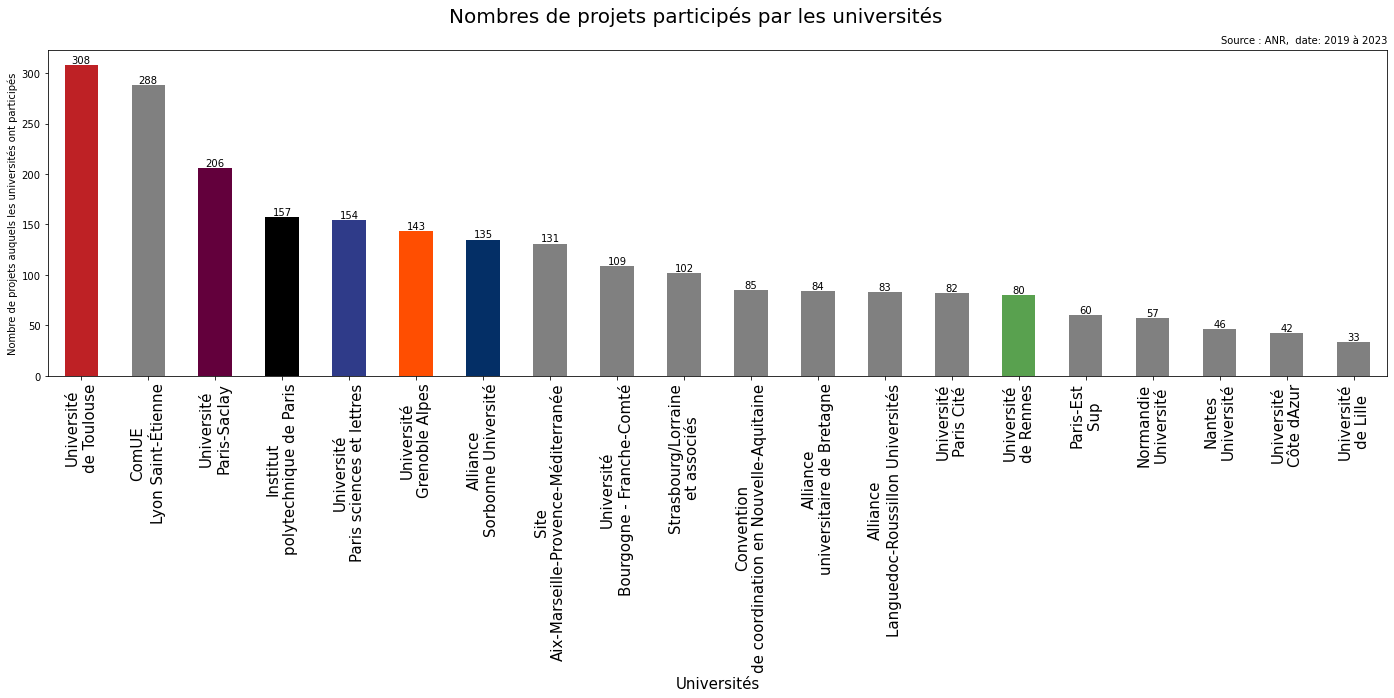

In [98]:
data_counts = df_projets_ia.name.dropna().value_counts()

plt.figure(figsize=(24, 6))
ax = data_counts[:20].plot(kind='bar', color=[color_dict.get(u, 'grey') for u in data_counts[:20].index])

for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, f'{v}', ha='center', va='bottom', color='black')
    

plt.suptitle(f"Nombres de projets participés par les universités", size=20)
plt.title('Source : ANR,  date: 2019 à 2023', size=10, loc='right')

plt.xlabel('Universités', size=15)
plt.ylabel("Nombre de projets auquels les universités ont participés", size=10)
xticklabels = [label.split(' ', 1)[0]+'\n'+label.split(' ', 1)[1] for label in data_counts.index[:20]]
ax.set_xticklabels(xticklabels, rotation='vertical', fontsize=15)
plt.show()